# Predicting listing prices

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels
import sklearn
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn__version
from IPython.display import Image

In [2]:
%matplotlib inline

### Read Data

In [3]:
listings = pd.read_csv('data/seattle_listings.csv')

In [4]:
listings.columns.values

array(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       

In [5]:
df = listings[['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'zipcode', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating', 'cancellation_policy', 'reviews_per_month']]

In [6]:
df.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating,cancellation_policy,reviews_per_month
0,96%,100%,f,3.0,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,$85.00,207,95.0,moderate,4.07
1,98%,100%,t,6.0,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,$150.00,43,96.0,strict,1.48
2,67%,100%,f,2.0,98119,House,Entire home/apt,11,4.5,5.0,7.0,$975.00,20,97.0,strict,1.15
3,NaN,NaN,f,1.0,98119,Apartment,Entire home/apt,3,1.0,0.0,2.0,$100.00,0,NaN,flexible,NaN
4,100%,NaN,f,2.0,98119,House,Entire home/apt,6,2.0,3.0,3.0,$450.00,38,92.0,strict,0.89


In [7]:
# % of NaN values
(len(df) - df.count())/len(df) * 100

host_response_rate      13.698271
host_acceptance_rate    20.246202
host_is_superhost        0.052383
host_listings_count      0.052383
zipcode                  0.183342
property_type            0.026192
room_type                0.000000
accommodates             0.000000
bathrooms                0.419068
bedrooms                 0.157150
beds                     0.026192
price                    0.000000
number_of_reviews        0.000000
review_scores_rating    16.946045
cancellation_policy      0.000000
reviews_per_month       16.422211
dtype: float64

In [12]:
# drop NaN rows
df2 = df.dropna(axis=0)

In [13]:
# % of rows dropped
(len(df) - len(df2))/len(df) * 100

30.434782608695656

In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2656 entries, 0 to 3814
Data columns (total 16 columns):
host_response_rate      2656 non-null object
host_acceptance_rate    2656 non-null object
host_is_superhost       2656 non-null object
host_listings_count     2656 non-null float64
zipcode                 2656 non-null object
property_type           2656 non-null object
room_type               2656 non-null object
accommodates            2656 non-null int64
bathrooms               2656 non-null float64
bedrooms                2656 non-null float64
beds                    2656 non-null float64
price                   2656 non-null object
number_of_reviews       2656 non-null int64
review_scores_rating    2656 non-null float64
cancellation_policy     2656 non-null object
reviews_per_month       2656 non-null float64
dtypes: float64(6), int64(2), object(8)
memory usage: 352.8+ KB


In [25]:
df2.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating,cancellation_policy,reviews_per_month
0,96%,100%,f,3.0,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,$85.00,207,95.0,moderate,4.07
1,98%,100%,t,6.0,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,$150.00,43,96.0,strict,1.48
2,67%,100%,f,2.0,98119,House,Entire home/apt,11,4.5,5.0,7.0,$975.00,20,97.0,strict,1.15
6,100%,100%,t,1.0,98119,House,Private room,2,1.0,1.0,1.0,$80.00,58,99.0,moderate,2.46
7,100%,100%,t,5.0,98119,Cabin,Private room,2,1.0,1.0,1.0,$60.00,173,97.0,strict,4.73


In [11]:
pd.options.mode.chained_assignment = None # default: 'warn'

df2['host_response_rate'] = df2['host_response_rate'].astype(str)
df2['host_acceptance_rate'] = df2['host_acceptance_rate'].astype(str)
df2['price'] = df2['price'].astype(str)

In [26]:
# clean data
df2['host_acceptance_rate'] = df2['host_acceptance_rate'].str.replace('%', '').astype('float')
df2['price'] = df2['price'].str.replace('[$, ]', '').astype('float')
df2['host_response_rate'] = df2['host_response_rate'].str.replace('%', '').astype('float')

In [28]:
df2['superhost'] = np.where(df2['host_is_superhost'] == 't', 1, 0)
del df2['host_is_superhost']

In [29]:
# select non-numeric variables and crate dummies
non_num_vars = df2.select_dtypes(include=['object']).columns

In [30]:
non_num_vars

Index(['zipcode', 'property_type', 'room_type', 'cancellation_policy'], dtype='object')

In [31]:
df2[non_num_vars].head()

,zipcode,property_type,room_type,cancellation_policy
0,98119,Apartment,Entire home/apt,moderate
1,98119,Apartment,Entire home/apt,strict
2,98119,House,Entire home/apt,strict
6,98119,House,Private room,moderate
7,98119,Cabin,Private room,strict


In [32]:
dummy_vars = pd.get_dummies(df2[non_num_vars])

In [33]:
dummy_vars.head()

,zipcode_98101,zipcode_98102,zipcode_98103,zipcode_98104,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,...,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [34]:
# drop non-numeric variables from df2 and add the dummies
df3 = df2.drop(non_num_vars, axis=1)
df3 = pd.merge(df3, dummy_vars, left_index=True, right_index=True)
df3.head()

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating,...,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,96.0,100.0,3.0,4,1.0,1.0,1.0,85.0,207,95.0,...,0,0,0,0,1,0,0,0,1,0
1,98.0,100.0,6.0,4,1.0,1.0,1.0,150.0,43,96.0,...,0,0,0,0,1,0,0,0,0,1
2,67.0,100.0,2.0,11,4.5,5.0,7.0,975.0,20,97.0,...,0,0,0,0,1,0,0,0,0,1
6,100.0,100.0,1.0,2,1.0,1.0,1.0,80.0,58,99.0,...,0,0,0,0,0,1,0,0,1,0
7,100.0,100.0,5.0,2,1.0,1.0,1.0,60.0,173,97.0,...,0,0,0,0,0,1,0,0,0,1


### Summary Stats

Text(0.5, 1.0, 'Histogram of listing prices')

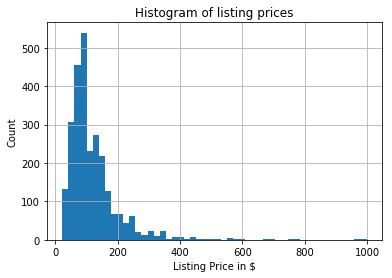

In [35]:
# Some summary stats
df3['price'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Listing Price in $')
plt.title('Histogram of listing prices')

Text(0.5, 1.0, '# of Bedrooms V.S. Price')

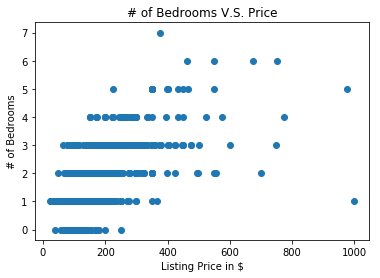

In [36]:
plt.scatter(df3['price'], df3['bedrooms'])
plt.ylabel('# of Bedrooms')
plt.xlabel('Listing Price in $')
plt.title('# of Bedrooms V.S. Price')

Text(0.5, 1.0, '# of Reviews V.S. Price')

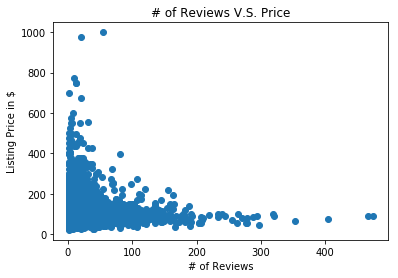

In [37]:
plt.scatter(df3['number_of_reviews'], df3['price'])
plt.ylabel('Listing Price in $')
plt.xlabel('# of Reviews')
plt.title('# of Reviews V.S. Price')

Text(0.5, 0, 'Listing Price in $')

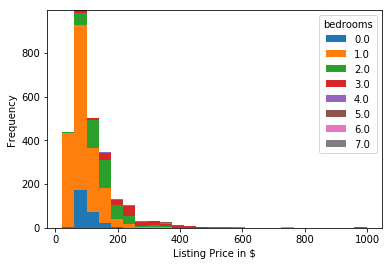

In [39]:
df3.pivot(columns='bedrooms', values='price').plot.hist(stacked=True, bins=25)
plt.xlabel('Listing Price in $')

Text(0.5, 0, 'Listing Price in $')

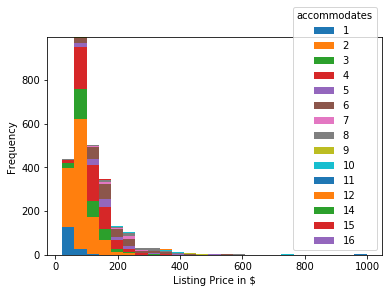

In [40]:
df3.pivot(columns = 'accommodates', values = 'price').plot.hist(stacked=True, bins=25)
plt.xlabel('Listing Price in $')

Text(0.5, 0, 'Listing Price in $')

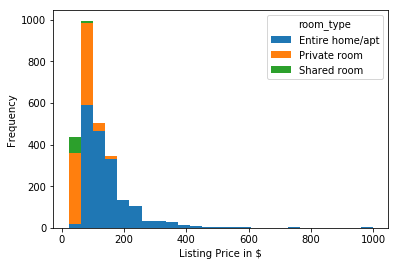

In [41]:
df2.pivot(columns = 'room_type', values = 'price').plot.hist(stacked=True, bins=25)
plt.xlabel('Listing Price in $')

In [43]:
cols = ['number_of_reviews', 'host_acceptance_rate', 'host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price']

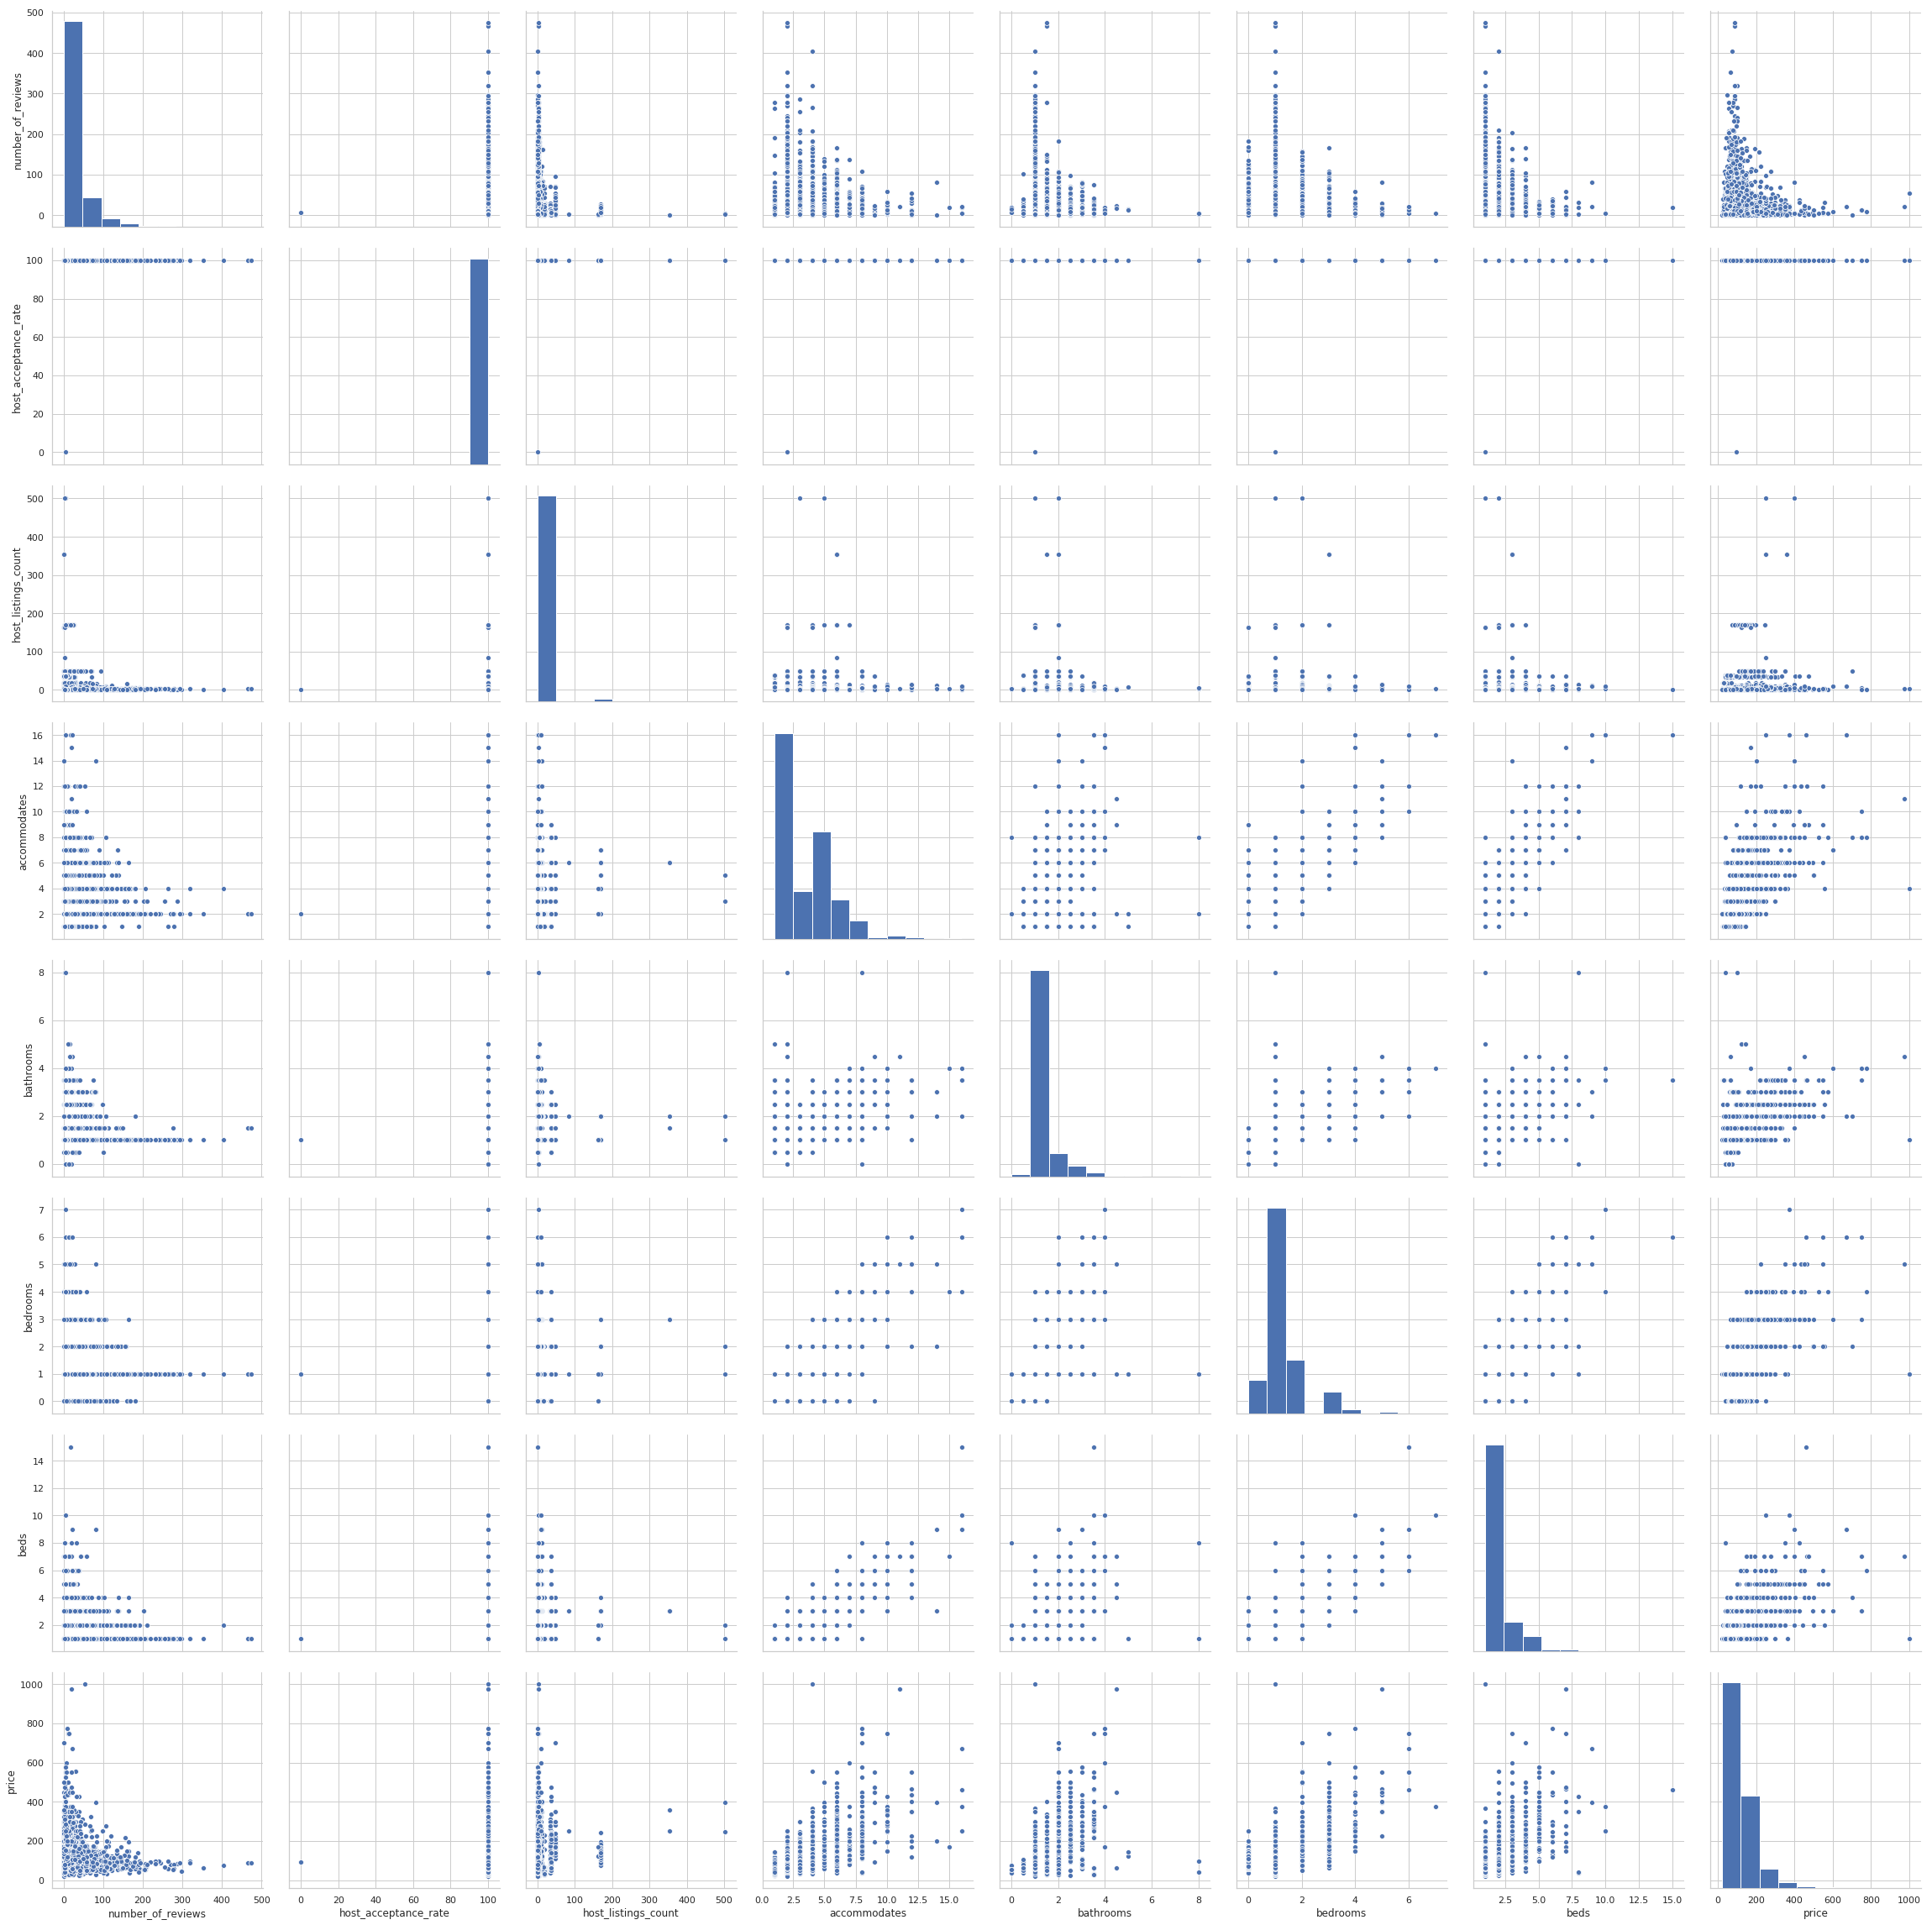

In [45]:
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df3[cols], height=4)
plt.show()

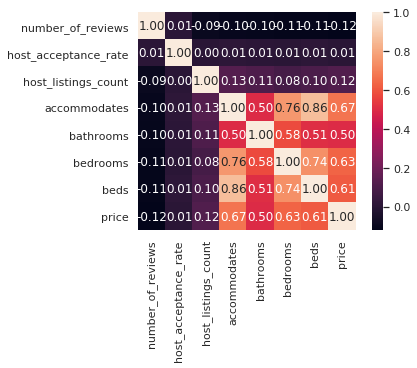

In [46]:
# heatmap
corrs = np.corrcoef(df3[cols].values.T)
sns.set(font_scale=1)
hm=sns.heatmap(corrs, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=cols, xticklabels=cols)

### Prediction Examples

In [47]:
# split into test and training data
np.random.seed(1)

indices = np.random.permutation(len(df3))
train_size = int(round(0.8*len(df3)))
test_size = len(df3) - train_size

In [48]:
y = df3['price']
x = df3.drop(['price'], axis=1)

In [51]:
x_train = x.iloc[indices[0:train_size]]
y_train = y.iloc[indices[0:train_size]]
x_test = x.iloc[indices[train_size+1:]]
y_test = y.iloc[indices[train_size+1:]]

In [55]:
x2 = x_train.as_matrix()
y2 = y_train.as_matrix()

/Users/best_zld/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/best_zld/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [56]:
import statsmodels.api as sm

In [57]:
olsmod = sm.OLS(y2, x2)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     73.20
Date:                Fri, 08 Feb 2019   Prob (F-statistic):               0.00
Time:                        22:38:34   Log-Likelihood:                -11196.
No. Observations:                2125   AIC:                         2.251e+04
Df Residuals:                    2067   BIC:                         2.284e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1913      0.100     -1.922      0.0

In [58]:
x0 = x_test.as_matrix()
y0 = y_test.as_matrix()

/Users/best_zld/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/best_zld/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [59]:
ypred = olsres.predict(x0)

In [60]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [61]:
rms_ols = sqrt(mean_squared_error(y0, ypred))

In [62]:
rms_ols

56.38292278388185

/Users/best_zld/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


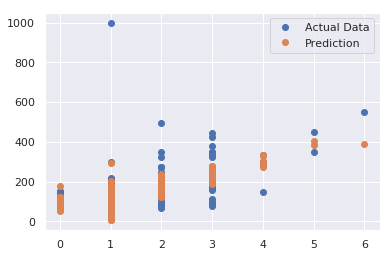

In [63]:
# plot predictions against true values as function of bedrooms
beds = x_test['bedrooms'].as_matrix()

fig, ax = plt.subplots()
ax.plot(beds, y0, 'o', label = 'Actual Data')
ax.plot(beds, ypred, 'o', label='Prediction')
ax.legend(loc='best')

### Different Method

In [64]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [65]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [66]:
slr = linear_model.LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_pred = slr.predict(X_test)

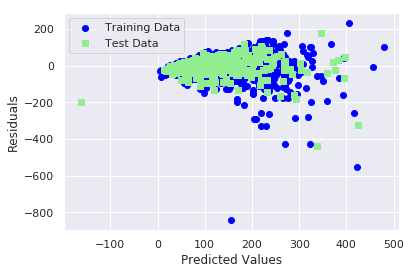

In [67]:
# plot
plt.scatter(y_train_pred, y_train_pred-y_train, c='blue', marker='o', label='Training Data')
plt.scatter(y_pred, y_pred-y_test, c='lightgreen', marker='s', label='Test Data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.legend(loc='upper left')
plt.show()

In [68]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [69]:
rms_ols2 = sqrt(mean_squared_error(y_test, y_pred))
print('MSE train: %.3f, test: %.3f'%(mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_pred)))
print('R^2 train: %.3f, test: %.3f'%(r2_score(y_train, y_train_pred), r2_score(y_test, y_pred)))

MSE train: 2584.422, test: 2074.297
R^2 train: 0.612, test: 0.683


### Random Forest

In [70]:
from sklearn.ensemble import RandomForestRegressor

In [71]:
rf = RandomForestRegressor(n_estimators=500, criterion='mse', random_state=3, n_jobs=1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

In [72]:
print('MSE train: %.3f, test: %.3f'%(mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_pred)))
print('R^2 train: %.3f, test: %.3f'%(r2_score(y_train, y_train_pred), r2_score(y_test, y_pred)))

MSE train: 363.434, test: 1976.750
R^2 train: 0.945, test: 0.698


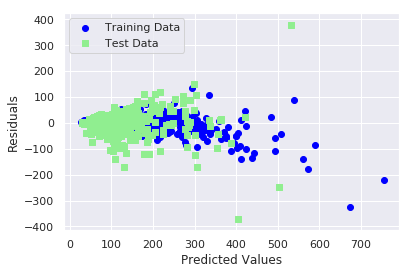

In [73]:
plt.scatter(y_train_pred, y_train_pred-y_train, c='blue', marker='o', label='Training Data')
plt.scatter(y_pred, y_pred-y_test, c='lightgreen', marker='s', label='Test Data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.show()

In [74]:
rmse_rf = sqrt(mean_squared_error(y_test, y_pred))

### Comparison between Models

In [76]:
compare = pd.Series([rms_ols, rms_ols2, rmse_rf], index=['ols1', 'ols2', 'random forest'])

In [77]:
compare

ols1             56.382923
ols2             45.544445
random forest    44.460654
dtype: float64